# Basic Setup

In [ ]:
## Basic Imports
import torch
import numpy as np
!pip install timm
import timm
import random
import cv2

     |████████████████████████████████| 431 kB 13.7 MB/s 


In [ ]:
## Mounting the drive file system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_seed(seed):
    """
    This method helps to seed the libraries, it is important to get reproducible results
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
set_seed(42)

#50-50 Split

##Data Setup

In [ ]:
import pickle
from random import sample
def get_data(train,base,number_of_frames,remove_gestures,f_size):
  
  if train:
    with open(base+'train.pickle', 'rb') as f:
        data = pickle.load(f)
  else:
    with open(base+'test.pickle', 'rb') as f:
      data = pickle.load(f)

  X = []
  y = []

  keys = np.zeros(11-len(remove_gestures),dtype=int)
  j=0
  for i in range(11):
    if i not in remove_gestures:#list of gestures to be removed [3,4]
      keys[j]=i
      j= j+1

  keys = list(keys)    
  for key in keys:
    gesture_data = data[key]
    for i in range(len(gesture_data)):
      datapt_arr = gesture_data[i]
      datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
      datapt1 = np.sum(datapt,axis=2)
      datapt2 = np.sum(datapt,axis=1)
      datapt = np.hstack((datapt1,datapt2))
      datapt = datapt.T
      num_frames = np.shape(datapt)[1]

      if num_frames < number_of_frames:
          size = number_of_frames - num_frames
          use = np.zeros((64,size))
          datapt = np.hstack((datapt,use))      ## subsampling and extension so that finally all sequences are of fixed length 

      if num_frames > number_of_frames:
          datapt = datapt.T
          datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:]
          datapt = datapt.T

        
      datapt = np.reshape(datapt,(64,number_of_frames,1))
      datapt = np.tile(datapt,(1,1,3))
      datapt = cv2.resize(datapt,(f_size,f_size),interpolation=cv2.INTER_CUBIC)
      
      minimum = datapt.min()
      maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
      datapt = (datapt-minimum)/((maximum-minimum))

      X.append(datapt)
      y_temp = np.zeros(11-len(remove_gestures))
      y_temp[keys.index(key)]=1
      y.append(y_temp)
  return X,y

In [ ]:
from torch.utils.data import Dataset
class SoliData(Dataset):
  def __init__(self,train,X_train,y_train,X_test,y_test):
        if train:
            self.data= X_train               # in this just define dataset of train and test after split into self.data
            self.target = y_train
        else:
            self.data = X_test
            self.target = y_test             

  def __getitem__(self, index):
        target = self.target[index]                                                     # gets data point sequentially
        x = self.data[index]
        x = np.swapaxes(x,0,2)
        x = np.swapaxes(x,1,2)
        return x, target

  def __len__(self):
        return len(self.data)

In [ ]:
base = "/content/drive/MyDrive/data_soli_dictionaries/"
X_train, y_train = get_data(True,base,40,[],224)
X_test, y_test = get_data(False,base,40,[],224)

In [ ]:
print(X_train[0].shape)

(224, 224, 3)


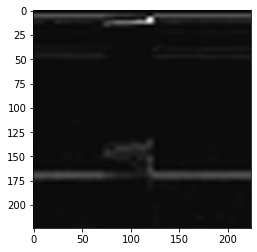

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[700])

## Model Setup

In [ ]:
def freeze_all_blocks(model,num_blocks,device):
    """
    This method is used to freeze all blocks of ViT
    """
    if device == "cuda":
      for block in model.module.blocks[:num_blocks]:
          for param in block.parameters():
              param.requires_grad=False
    else:
      for block in model.blocks[:num_blocks]:
          for param in block.parameters():
              param.requires_grad=False

    return model

In [ ]:
def unfreeze_blocks(model, block_no,device):
    """
    This method is used to unfreeze some blocks of the pretrained-ViT
    """
    if device =="cuda":
      block=model.module.blocks[block_no]
      for param in block.parameters():
          param.requires_grad=True
    else:
      block=model.blocks[block_no]
      for param in block.parameters():
          param.requires_grad=True

    return model

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=11)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [ ]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

## Training Setup

In [ ]:
import torch.nn as nn
import torch.optim as opti
import torch.nn.functional as func
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import statistics

In [ ]:
def visualization(loss_arr,epo):
  x = np.linspace(1,epo,epo)
  plt.plot(x,loss_arr, label='Training Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.title('Training Curve')
  plt.legend()
  plt.show()

In [ ]:
def train_single_epoch(lr,criterion,optimizer,device,nnet,trainloader,bsize,loss):
  nnet.train()                        ## a pytorch routine it is to turn ON some advanced layers which were turned OFF during testing  
  tloss =0
  for index,(x,y) in enumerate(trainloader):
    x= x.to(device).float()
    if loss == 'CrossEntropy':
      y = y.to(device).long()
    else:
      y = y.to(device).float()
    optimizer.zero_grad()          ## zeroing the gradients to nullify the effects of previous iterations
    pred_y = nnet(x)
    loss = criterion(pred_y,y)
    loss.backward()
    optimizer.step()
    tloss += loss.item() 
  tloss /= index

  return tloss

In [ ]:
def training_scratch(nnet,lr,criterion, epochs, batch_size,loss,mom,trainset,sgd,verbose):
  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print('Data Setup Completed')

  print('Building model')

  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []

  for epoch in range(epochs):
    l= train_single_epoch(lr,criterion,optimizer,device,nnet,trainloader,batch_size,loss) 
    trainloss.append(l)

    if verbose:
      print("The loss at epoch {} was ".format(epoch)+str(l))
  
  visualization(trainloss,epochs)

  print("Training Completed.")
  return nnet

In [ ]:
def training(nnet,lr,criterion, epochs, batch_size,loss,mom,trainset,sgd,unfreeze_after,num_blocks,lr_decay,verbose):
  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print('Data Setup Completed')

  print('Building model')

  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True
  nnet = freeze_all_blocks(nnet,num_blocks,device)

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []
  block_to_unfreeze=0

  for epoch in range(epochs):
    l= train_single_epoch(lr,criterion,optimizer,device,nnet,trainloader,batch_size,loss) 
    trainloss.append(l)

    if block_to_unfreeze<=(num_blocks-1):
      if (epoch+1)%unfreeze_after==0:
        nnet=unfreeze_blocks(nnet,block_to_unfreeze,device)
        block_to_unfreeze+=1

        if sgd:
          optimizer = opti.SGD(nnet.parameters(), lr_decay*lr,mom) 
        else:
          optimizer = opti.Adam(nnet.parameters(), lr_decay*lr)
        lr = lr*lr_decay

    if verbose:
      print("The loss at epoch {} was ".format(epoch)+str(l))
  
  visualization(trainloss,epochs)

  print("Training Completed.")
  return nnet

In [ ]:
from sklearn.metrics import confusion_matrix

def test(testset,nnet,device,loss):
  predictions = []
  actual = []
  
  testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
  nnet.eval()                     ## a pytorch routine it is to turn OFF some advanced layers during testing   
  correct = 0
  total = 0
  with torch.no_grad():          ## turn OFF autograd
    for index,(x,y) in enumerate(testloader):
      total = total + 1
      x= x.to(device).float()

      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()

      pred_ysf = nnet(x)
      pred_y = torch.max(pred_ysf,1)[1][0]
      check_y = torch.max(y,1)[1][0]    ## to get the index of maximum value
      predictions.append(pred_y.item())
      actual.append(check_y.item())
      if (pred_y) == (check_y) :
        correct = correct +1
  conf = confusion_matrix(actual,predictions)
  return (correct/total),conf

In [ ]:
def loss_fn(outputs, labels):
    """
    custom loss function: Implements Cross Entropy loss for one hot output representations
    refer: https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/2
    """
    _, label = labels.max(dim=1)     ## because labels are of dimension (b_size,num_classes)
    return nn.CrossEntropyLoss()(outputs, label)

## Training

### Training from scratch

Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 2.89311052477637
The loss at epoch 1 was 2.533613609713177
The loss at epoch 2 was 2.504654413045839
The loss at epoch 3 was 2.5024871271710065
The loss at epoch 4 was 2.38041120351747
The loss at epoch 5 was 2.270278123922126
The loss at epoch 6 was 2.080661030702813
The loss at epoch 7 was 1.9673229455947876
The loss at epoch 8 was 1.9094179591467215
The loss at epoch 9 was 2.0801554391550465
The loss at epoch 10 was 1.9932362257048142
The loss at epoch 11 was 1.8996281707009604
The loss at epoch 12 was 1.8055882980657179
The loss at epoch 13 was 1.6782463317693666
The loss at epoch 14 was 1.5719463908395102
The loss at epoch 15 was 1.5186458992403606
The loss at epoch 16 was 1.4983584243197774
The loss at epoch 17 was 1.4314557383226794
The loss at epoch 18 was 1.3620694958886435
The loss at epoch 19 was 1.321884460227434
The loss at epoch 20 was 1.3467204848001169
The loss at epoch 21 was 1.3675893850104

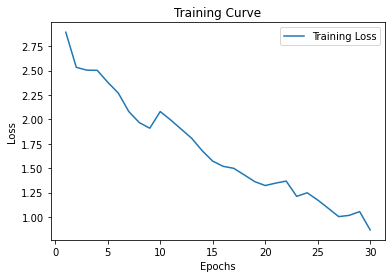

Training Completed.


In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=11)
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training_scratch(model,0.0003,loss_fn,30,32,'CrossEntropy',0.9,trainset,False,True)

In [ ]:
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

0.6466275659824047
[[116   0   0   3   0   2   0   0   0   0   3]
 [  0  94  13   1   0   0   0   1  13   2   0]
 [ 11  26  54   4   3   2   1   1  17   3   2]
 [ 23   0   2  82   3   6   1   0   1   5   1]
 [  0   0   4   0  42   4  42   8  17   7   0]
 [  0   0   1   8   0  48  29   5   3  30   0]
 [  0   0   0   0   0   0 118   3   0   3   0]
 [  0   0   0   0   1   0  29  92   2   0   0]
 [  0   2   5   0  12   0   5   2  73  25   0]
 [  0   0   1   1   6   7  23   4  14  68   0]
 [ 28   1   0   0   0   0   0   0   0   0  95]]


## Finetuning Pre-Trained

### ViT Base with IN 1k

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=11)

In [ ]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 1.2558183351228402
The loss at epoch 1 was 0.336710007384766
The loss at epoch 2 was 0.44414605564156245
The loss at epoch 3 was 0.2246985042164492
The loss at epoch 4 was 0.35367030234530916
The loss at epoch 5 was 0.16325974035574947
The loss at epoch 6 was 0.3526293680418369
The loss at epoch 7 was 0.13802189499053152
The loss at epoch 8 was 0.21340250657048337
The loss at epoch 9 was 0.12579116742884697
The loss at epoch 10 was 0.141564367468967
The loss at epoch 11 was 0.06553356750694991
The loss at epoch 12 was 0.09792844231002205
The loss at epoch 13 was 0.08331292237393385
The loss at epoch 14 was 0.09673308278433979
The loss at epoch 15 was 0.036348264797070866
The loss at epoch 16 was 0.05099113748969272
The loss at epoch 17 was 0.014792292420806492
The loss at epoch 18 was 0.02185983277732428
The loss at epoch 19 was 0.026419098402605645
The loss at epoch 20 was 0.03504025810775073
The loss at ep

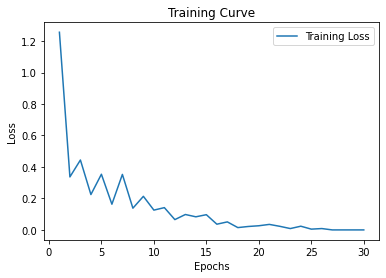

Training Completed.


In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=11)
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training(model,0.0003,loss_fn,30,32,'CrossEntropy',0.9,trainset,False,2.12,0.8,True)

In [ ]:
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

0.9758064516129032
[[116   0   0   4   0   0   0   0   0   0   4]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  0   0 121   3   0   0   0   0   0   0   0]
 [  9   0   2 112   1   0   0   0   0   0   0]
 [  0   0   1   1 122   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   1 123   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   0   0   0   2 122   0]
 [  4   0   0   1   0   0   0   0   0   0 119]]


Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 1.2688723449097123
The loss at epoch 1 was 0.34016608810702037
The loss at epoch 2 was 0.48363659305627954
The loss at epoch 3 was 0.20265914885283903
The loss at epoch 4 was 0.3955411065456479
The loss at epoch 5 was 0.16189507602952247
The loss at epoch 6 was 0.25698647635100885
The loss at epoch 7 was 0.19081977559903332
The loss at epoch 8 was 0.2094768186121486
The loss at epoch 9 was 0.14707982319212237
The loss at epoch 10 was 0.18237991057076428
The loss at epoch 11 was 0.0844186321225797
The loss at epoch 12 was 0.12237940979904907
The loss at epoch 13 was 0.04526438985323144
The loss at epoch 14 was 0.07814599979982906
The loss at epoch 15 was 0.03584001019907043
The loss at epoch 16 was 0.05453608597244331
The loss at epoch 17 was 0.008145558783516483
The loss at epoch 18 was 0.06368319811955972
The loss at epoch 19 was 0.011564284098418538
The loss at epoch 20 was 0.014685902692330865
The loss at

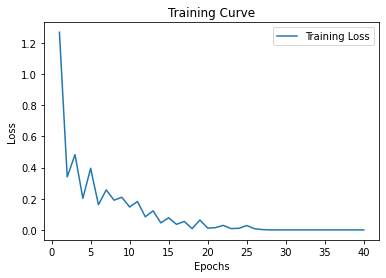

Training Completed.


In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=11)
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training(model,0.0003,loss_fn,40,32,'CrossEntropy',0.9,trainset,False,2,12,0.8,True)

In [ ]:
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

0.9772727272727273
[[117   0   0   1   0   0   0   0   0   0   6]
 [  0 123   0   0   0   0   0   0   1   0   0]
 [  3   0 119   0   1   0   0   0   0   1   0]
 [ 13   0   1 108   2   0   0   0   0   0   0]
 [  0   0   0   0 124   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   1 123   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   0   0   0   0 124   0]
 [  1   0   0   0   0   0   0   0   0   0 123]]


### ViT with ImageNet 21k

In [ ]:
from torchsummary import summary
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=11)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 1.347926448944003
The loss at epoch 1 was 0.34962425675503045
The loss at epoch 2 was 0.5716953811257385
The loss at epoch 3 was 0.2272414364093958
The loss at epoch 4 was 0.46572007013614786
The loss at epoch 5 was 0.20969309458552404
The loss at epoch 6 was 0.3123818279872107
The loss at epoch 7 was 0.1976563051169695
The loss at epoch 8 was 0.2825498498629692
The loss at epoch 9 was 0.1431564190533272
The loss at epoch 10 was 0.2108800606152346
The loss at epoch 11 was 0.13591479524147027
The loss at epoch 12 was 0.13318042549153053
The loss at epoch 13 was 0.06857376775249492
The loss at epoch 14 was 0.11303877042129983
The loss at epoch 15 was 0.04710623235333451
The loss at epoch 16 was 0.06722372449558163
The loss at epoch 17 was 0.0407997252240907
The loss at epoch 18 was 0.039999259995204546
The loss at epoch 19 was 0.06906089474897842
The loss at epoch 20 was 0.05097869263679672
The loss at epoch 2

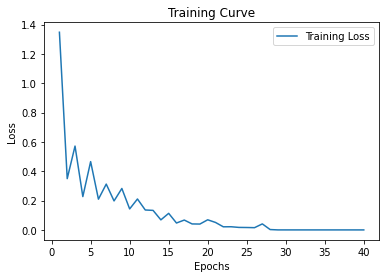

Training Completed.


In [ ]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=11)
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training(model,0.0003,loss_fn,40,32,'CrossEntropy',0.9,trainset,False,2,12,0.8,True)

In [ ]:
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

0.9831378299120235
[[118   0   0   4   0   0   0   0   0   0   2]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  0   0 119   2   2   1   0   0   0   0   0]
 [  8   0   1 114   1   0   0   0   0   0   0]
 [  0   0   0   0 124   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   1 123   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   0   0   0   0 124   0]
 [  1   0   0   0   0   0   0   0   0   0 123]]


### Ablation Studies on IN-21k

#### 3 blocks

Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 2.3396287491155223
The loss at epoch 1 was 1.6802233901134758
The loss at epoch 2 was 1.213671863079071
The loss at epoch 3 was 1.1507957106412843
The loss at epoch 4 was 0.6516251376895017
The loss at epoch 5 was 0.5304331523041392
The loss at epoch 6 was 0.46465698577636894
The loss at epoch 7 was 0.33634323089621787
The loss at epoch 8 was 0.28838887559466586
The loss at epoch 9 was 0.21260325246772102
The loss at epoch 10 was 0.1796799565470496
The loss at epoch 11 was 0.1382059123973514
The loss at epoch 12 was 0.10024969353405543
The loss at epoch 13 was 0.12973845147982585
The loss at epoch 14 was 0.09809041218182375
The loss at epoch 15 was 0.06502157760524126
The loss at epoch 16 was 0.10117786806509939
The loss at epoch 17 was 0.08105135361425751
The loss at epoch 18 was 0.14749072256043208
The loss at epoch 19 was 0.05910567519103372
The loss at epoch 20 was 0.04615772761361197
The loss at epoch 2

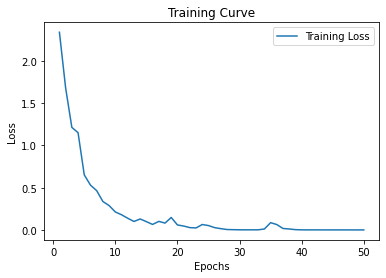

Training Completed.
0.9450146627565983
[[111   0   0   6   0   0   0   0   0   0   7]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  8   1 108   4   2   0   0   0   0   1   0]
 [ 10   0   1 107   3   0   0   0   0   1   2]
 [  0   0   1   0 119   1   0   0   3   0   0]
 [  0   0   0   0   0 120   0   0   0   4   0]
 [  0   0   0   0   0   4 120   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 123   1   0]
 [  0   0   0   0   2   7   2   0   2 111   0]
 [  2   0   0   0   0   0   0   0   0   0 122]]


In [ ]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=11)
blocks_to_keep = 3
model.blocks = torch.nn.Sequential(*[model.blocks[i] for i in range(blocks_to_keep)])
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training(model,0.0003,loss_fn,50,32,'CrossEntropy',0.9,trainset,False,3,blocks_to_keep,0.5,True)
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

#### 6 blocks

Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 1.7145504549492236
The loss at epoch 1 was 0.7892050895580026
The loss at epoch 2 was 0.445246831275696
The loss at epoch 3 was 0.6702941850174305
The loss at epoch 4 was 0.26306866750467656
The loss at epoch 5 was 0.17764956348164138
The loss at epoch 6 was 0.3282253285653369
The loss at epoch 7 was 0.14467681554514308
The loss at epoch 8 was 0.11919156280021335
The loss at epoch 9 was 0.14309956077053104
The loss at epoch 10 was 0.07499324755613195
The loss at epoch 11 was 0.10774179554522731
The loss at epoch 12 was 0.1264652389231636
The loss at epoch 13 was 0.05695701860497857
The loss at epoch 14 was 0.048107879431268506
The loss at epoch 15 was 0.04505018885572289
The loss at epoch 16 was 0.02224553579756947
The loss at epoch 17 was 0.012647043316635888
The loss at epoch 18 was 0.00893005671596891
The loss at epoch 19 was 0.01729363537573548
The loss at epoch 20 was 0.005734003286877766
The loss at ep

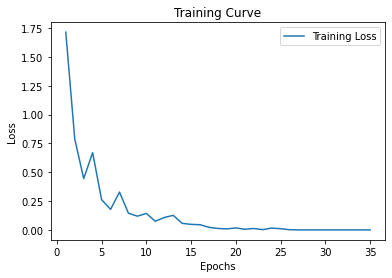

Training Completed.
0.967008797653959
[[113   0   4   5   0   0   0   0   0   0   2]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  0   0 116   4   1   0   0   0   0   3   0]
 [  7   0   1 111   1   2   0   0   0   0   2]
 [  0   0   1   0 119   0   0   0   1   3   0]
 [  0   0   0   0   0 123   0   0   0   1   0]
 [  0   0   0   0   0   1 123   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 123   1   0]
 [  0   0   0   0   1   0   0   0   1 122   0]
 [  1   0   1   1   0   0   0   0   0   0 121]]


In [ ]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=11)
blocks_to_keep = 6
model.blocks = torch.nn.Sequential(*[model.blocks[i] for i in range(blocks_to_keep)])
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training(model,0.0003,loss_fn,35,32,'CrossEntropy',0.9,trainset,False,3,blocks_to_keep,0.64,True)
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 2.0165208134540293
The loss at epoch 1 was 1.051939567854238
The loss at epoch 2 was 0.5697142294673032
The loss at epoch 3 was 0.7111676404642504
The loss at epoch 4 was 0.31723826551853224
The loss at epoch 5 was 0.24527521275503691
The loss at epoch 6 was 0.28121346737756286
The loss at epoch 7 was 0.14979156752138637
The loss at epoch 8 was 0.11067826331181582
The loss at epoch 9 was 0.1413228299122217
The loss at epoch 10 was 0.10130693079080692
The loss at epoch 11 was 0.04441188101461807
The loss at epoch 12 was 0.054829853695145876
The loss at epoch 13 was 0.027987727787085744
The loss at epoch 14 was 0.014479440201052227
The loss at epoch 15 was 0.016678473747032154
The loss at epoch 16 was 0.006861483679575369
The loss at epoch 17 was 0.030379736322238175
The loss at epoch 18 was 0.01224475335817091
The loss at epoch 19 was 0.004409373882713966
The loss at epoch 20 was 0.0006435136019717902
The los

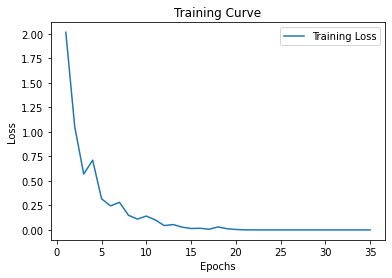

Training Completed.
0.9721407624633431
[[118   0   0   3   0   0   0   0   0   0   3]
 [  0 123   0   0   0   0   0   0   1   0   0]
 [  3   0 115   1   1   0   0   0   0   4   0]
 [ 10   0   1 110   3   0   0   0   0   0   0]
 [  0   0   0   0 124   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   2 122   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   1   0   0   0   0 123   0]
 [  5   0   0   0   0   0   0   0   0   0 119]]


In [ ]:
model = timm.create_model('vit_base_patch32_224_in21k', pretrained=True, num_classes=11)
blocks_to_keep = 6
model.blocks = torch.nn.Sequential(*[model.blocks[i] for i in range(blocks_to_keep)])
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training(model,0.0003,loss_fn,35,32,'CrossEntropy',0.9,trainset,False,3,blocks_to_keep,0.64,True)
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

#### 9 blocks

Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 1.6077949016593223
The loss at epoch 1 was 0.5848031570745069
The loss at epoch 2 was 0.6315476977547934
The loss at epoch 3 was 0.2931257382381794
The loss at epoch 4 was 0.38806694927950236
The loss at epoch 5 was 0.20980044142451398
The loss at epoch 6 was 0.24021344185741836
The loss at epoch 7 was 0.14588709777697575
The loss at epoch 8 was 0.2015944777359796
The loss at epoch 9 was 0.09500857511925143
The loss at epoch 10 was 0.11674097412114226
The loss at epoch 11 was 0.059133226306415924
The loss at epoch 12 was 0.11101930850553651
The loss at epoch 13 was 0.03137499264571383
The loss at epoch 14 was 0.050188273160317695
The loss at epoch 15 was 0.03249268662076184
The loss at epoch 16 was 0.01871162531985414
The loss at epoch 17 was 0.018028790097708036
The loss at epoch 18 was 0.015496545470404969
The loss at epoch 19 was 0.0037140773882890434
The loss at epoch 20 was 0.019735639820282813
The loss

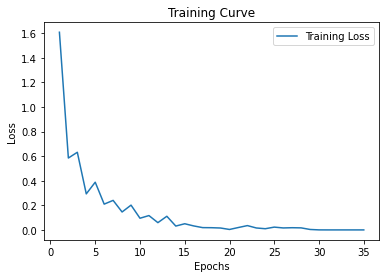

Training Completed.
0.9794721407624634
[[116   0   0   5   0   0   0   0   0   0   3]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  1   0 120   3   0   0   0   0   0   0   0]
 [  6   0   1 113   4   0   0   0   0   0   0]
 [  0   0   0   1 123   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   0 124   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   0   0   0   0 124   0]
 [  3   0   0   1   0   0   0   0   0   0 120]]


In [ ]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=11)
blocks_to_keep = 9
model.blocks = torch.nn.Sequential(*[model.blocks[i] for i in range(blocks_to_keep)])
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training(model,0.0003,loss_fn,35,32,'CrossEntropy',0.9,trainset,False,2,blocks_to_keep,0.75,True)
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

Data Setup Started
Data Setup Completed
Building model
The loss at epoch 0 was 2.026282690292181
The loss at epoch 1 was 1.1379224228304485
The loss at epoch 2 was 0.85209617434546
The loss at epoch 3 was 0.4212559485851332
The loss at epoch 4 was 0.4815190441386644
The loss at epoch 5 was 0.23080352659142295
The loss at epoch 6 was 0.30592831336828163
The loss at epoch 7 was 0.13574719827535542
The loss at epoch 8 was 0.19501902249663375
The loss at epoch 9 was 0.11454219674301702
The loss at epoch 10 was 0.11533037330522093
The loss at epoch 11 was 0.05479810503852922
The loss at epoch 12 was 0.06563977810532548
The loss at epoch 13 was 0.04042086564545888
The loss at epoch 14 was 0.03669403824240489
The loss at epoch 15 was 0.01084465776275042
The loss at epoch 16 was 0.007390112343357963
The loss at epoch 17 was 0.019614426739281043
The loss at epoch 18 was 0.006287343261647038
The loss at epoch 19 was 0.0009121371074078799
The loss at epoch 20 was 0.000153455516843932
The loss at 

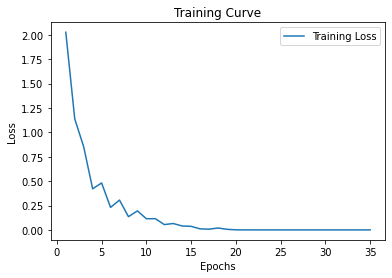

Training Completed.
0.9728739002932552
[[115   0   1   3   0   0   0   0   0   0   5]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  4   0 115   1   3   0   0   0   0   1   0]
 [  6   0   1 115   1   0   0   0   0   0   1]
 [  0   0   0   0 124   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   2 122   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   1   0   0   0 123   0]
 [  6   0   0   1   0   0   0   0   0   0 117]]


In [ ]:
model = timm.create_model('vit_base_patch32_224_in21k', pretrained=True, num_classes=11)
blocks_to_keep = 9
model.blocks = torch.nn.Sequential(*[model.blocks[i] for i in range(blocks_to_keep)])
trainset = SoliData(True,X_train,y_train,X_test,y_test)
model = training(model,0.0003,loss_fn,35,32,'CrossEntropy',0.9,trainset,False,2,blocks_to_keep,0.75,True)
testset = SoliData(False,X_train,y_train,X_test,y_test)
accu,conf_mat = test(testset,model,device,'CrossEntropy')
print(accu)
print(conf_mat)

## TODO

Training from scratch[doesn't seem a good idea]         
change optimizer settings to add some weight decay[to prevent overfit]         
ViViT       
Increasing epcohs             
Using larger/Huge ViT       
Metric learning (Triplet loss + AM Softmax)       
Try out some augmentations          
Try out 384 resolution as well      
Patch_size for model